## Deep Learning Applied to Images - Fine-tuning

#### Prof. Thomas da Silva Paula

### Fine-tuning example

* Using Pytorch
* Using Resnet18
* Using Stanford dogs dataset (http://vision.stanford.edu/aditya86/ImageNetDogs/)
* To be used as a reference

### Imports

In [1]:
import time
import torch
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import torchvision
import torch.nn as nn
import torch.optim as optim

from torchvision import models
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

### Setting up data transforms and dataset

In [2]:
train_path = '/datasets/thomas/datasets/stanford_dogs/train/'
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_path, transform=train_transforms)

test_path = '/datasets/thomas/datasets/stanford_dogs/test/'
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder(test_path, transform=test_transforms)

### Train and test methods

In [3]:
def train(model, train_loader, optimizer, criterion, epoch, device):
    model.train()

    total = 0
    total_loss = 0.0
    total_corrects = 0

    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        total += labels.size(0)
        total_corrects += (preds == labels).sum().item()

    epoch_loss = total_loss / total
    epoch_acc = total_corrects / total
    print('Loss: %.3f Acc: %.3f' % (epoch_loss, epoch_acc))


def test(model, test_loader, criterion, epoch, device):
    model.eval()

    total = 0
    total_loss = 0.0
    total_corrects = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader, 0):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            loss = criterion(outputs, labels)

            total_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            total_corrects += (preds == labels).sum().item()

    epoch_loss = total_loss / total
    epoch_acc = total_corrects / total
    print('Test Loss: %.3f Test Acc: %.3f' % (epoch_loss, epoch_acc))

### Creating the model

In [4]:
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(train_dataset.classes))

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


### Setting up training

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
num_gpus = torch.cuda.device_count()
batch_size = 256 * num_gpus

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [7]:
if num_gpus > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
    
model = model.to(device)

Let's use 4 GPUs!


In [ ]:
# model.load_state_dict(torch.load('resnet18_dogs.th'))
# model.eval()

### Training

In [8]:
total_time = []
num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(num_epochs):
    print('-' * 10)
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    start_time = time.time()

    train(model, train_dataloader, optimizer, criterion, epoch, device)
    test(model, test_dataloader, criterion, epoch, device)

    end_time = time.time() - start_time
    print('Took: %2ds' % (end_time))
    total_time.append(end_time)


print('Finished training. Took %2ds (%2ds per epoch)' % (np.sum(total_time), np.mean(total_time)))

----------
Epoch 0/9
Loss: 4.773 Acc: 0.027
Test Loss: 4.251 Test Acc: 0.110
Took: 74s
----------
Epoch 1/9
Loss: 3.825 Acc: 0.252
Test Loss: 2.955 Test Acc: 0.429
Took: 42s
----------
Epoch 2/9
Loss: 2.749 Acc: 0.538
Test Loss: 2.103 Test Acc: 0.598
Took: 42s
----------
Epoch 3/9
Loss: 1.985 Acc: 0.659
Test Loss: 1.749 Test Acc: 0.676
Took: 42s
----------
Epoch 4/9
Loss: 1.527 Acc: 0.721
Test Loss: 1.450 Test Acc: 0.706
Took: 42s
----------
Epoch 5/9
Loss: 1.255 Acc: 0.755
Test Loss: 1.297 Test Acc: 0.720
Took: 42s
----------
Epoch 6/9
Loss: 1.075 Acc: 0.781
Test Loss: 1.168 Test Acc: 0.733
Took: 42s
----------
Epoch 7/9
Loss: 0.949 Acc: 0.800
Test Loss: 1.084 Test Acc: 0.744
Took: 42s
----------
Epoch 8/9
Loss: 0.849 Acc: 0.816
Test Loss: 1.010 Test Acc: 0.752
Took: 42s
----------
Epoch 9/9
Loss: 0.765 Acc: 0.836
Test Loss: 0.972 Test Acc: 0.757
Took: 42s
Finished training. Took 458s (45s per epoch)


In [15]:
torch.save(model, 'resnet18_dogs.th')

### Testing predictions

In [9]:
!wget https://uploads.metropoles.com/wp-content/uploads/2019/12/30161058/fff2-600x400.jpg -O dog.jpg

--2020-11-24 23:59:51--  https://uploads.metropoles.com/wp-content/uploads/2019/12/30161058/fff2-600x400.jpg
Resolving uploads.metropoles.com (uploads.metropoles.com)... 104.18.24.118, 104.18.25.118, 2606:4700::6812:1876, ...
Connecting to uploads.metropoles.com (uploads.metropoles.com)|104.18.24.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33336 (33K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>]  32.55K  --.-KB/s    in 0.001s  

2020-11-24 23:59:57 (46.5 MB/s) - ‘dog.jpg’ saved [33336/33336]



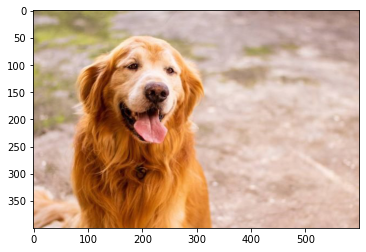

In [10]:
img = Image.open('dog.jpg')
plt.imshow(img)

In [11]:
x = test_transforms(img)
x = torch.unsqueeze(x, dim=0)
preds = model(x)
predicted_cls = np.argmax(preds.cpu().detach().numpy(), axis=1)
print(train_dataset.classes[predicted_cls[0]])

n02099601-golden_retriever


In [12]:
!wget https://static1.patasdacasa.com.br/articles/5/14/55/@/6702-cachorro-beagle-a-raca-pode-apresentar-articles_media_mobile-2.jpg -O dog2.jpg

--2020-11-25 00:00:59--  https://static1.patasdacasa.com.br/articles/5/14/55/@/6702-cachorro-beagle-a-raca-pode-apresentar-articles_media_mobile-2.jpg
Resolving static1.patasdacasa.com.br (static1.patasdacasa.com.br)... 23.222.241.112, 23.222.241.102
Connecting to static1.patasdacasa.com.br (static1.patasdacasa.com.br)|23.222.241.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44392 (43K) [image/jpeg]
Saving to: ‘dog2.jpg’

dog2.jpg            100%[===================>]  43.35K   196KB/s    in 0.2s    

2020-11-25 00:01:05 (196 KB/s) - ‘dog2.jpg’ saved [44392/44392]



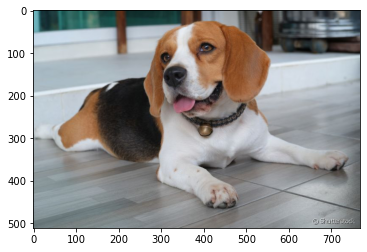

In [13]:
img = Image.open('dog2.jpg')
plt.imshow(img)

In [14]:
x = test_transforms(img)
x = torch.unsqueeze(x, dim=0)
preds = model(x)
predicted_cls = np.argmax(preds.cpu().detach().numpy(), axis=1)
print(train_dataset.classes[predicted_cls[0]])

n02088364-beagle


### Save classes to use after

In [1]:
with open('dog_classes.npy', 'wb') as f:
    np.save(f, train_dataset.classes)